# Create ROI from a bounding box (EPSG:4326) → HEALPix ROI

This notebook converts a lon/lat **bounding box** into a **HEALPix (nested) ROI**, using `healpix-geo`.

## What you’ll get
- **child-level** HEALPix cell IDs that cover the bbox
- **parent-level** cell IDs (optional coarser ROI)
- a **boundary footprint** polygon for plotting / masking workflows


## Steps
1. **Imports & helper(s)**  
   Load dependencies and define helper function(s) used for boundary construction/plotting.

2. **Define bbox and compute child-level coverage**  
   Set `(lon_min, lat_min, lon_max, lat_max)` and `child_level`, then compute `child_ids` covering the bbox.

3. **Convert to parent level and save IDs**  
   Set `parent_level`, convert `child_ids → parent_ids`, deduplicate, and save to `parent_ids.npz`.

4. **Build outer boundary ring and export footprint**  
   Choose `edge_level`, compute an outer ring around the ROI, build a boundary polygon, and export to `outer_boundary.geojson`.5. Build/plot a boundary footprint, save them to geojson

## Tuning
If the ROI boundary looks “cut” or missing along edges, increase the boundary refinement.
Here we use :
- `edge_level = child_level - 2` 

## Output 
Save exported ROI Parent cell IDs / Parent level(`parent_ids.npz`)  and footprint GeoJSON (`outer_boundary.geojson`) so `Prep_regrid.ipynb` can reuse them for masking/subsetting.


## Step 1 — Imports and helper functions


In [1]:
import numpy as np
import xarray as xr
import healpix_geo
from shapely.geometry import Polygon, box
from shapely.ops import unary_union, transform
import geopandas as gpd
from shapely.geometry import Polygon



In [2]:

def get_boundary(cell_ids, level, plot=False):
    lonv, latv = healpix_geo.nested.vertices(cell_ids, depth=level, ellipsoid="WGS84")

    def _unwrap_dateline(lons):
        lons = np.asarray(lons, dtype=float).copy()
        if (np.nanmax(lons) - np.nanmin(lons)) > 180:
            lons[lons < 0] += 360
        return lons

    polys = []
    for i in range(lonv.shape[0]):
        xs = _unwrap_dateline(lonv[i])
        ys = latv[i]
        #print(lonv[i],xs)
        coords = list(zip(xs, ys))
        if coords[0] != coords[-1]:
            coords.append(coords[0])
        polys.append(Polygon(coords))

    footprint = unary_union(polys)  # Polygon or MultiPolygon

    # Wrap final footprint to [-180, 180] for plotting/overlay with lon=-180..180 data
    footprint_180 = transform(wrap_lon_180, footprint)

    if plot:
        gdf_fp = gpd.GeoDataFrame(
            {"name": ["footprint"]},
            geometry=[footprint_180],
            crs="EPSG:4326",
        )
        ax = gdf_fp.plot(edgecolor="k", facecolor="none", linewidth=2)
        ax.set_aspect("equal")

    return footprint_180
def wrap_lon_180(x, y, z=None):
    x = ((np.asarray(x) + 180) % 360) - 180
    return (x, y) if z is None else (x, y, z)


## Step 2 — Define the ROI bounding box


In [3]:
# Define The ROI bbox in  (lon/lat)
lon_min, lon_max = -2.8, -1.97333
lat_min, lat_max = 47.04367, 47.31558


bbox = (lon_min, lat_min, lon_max, lat_max)

child_level = 13

# Find out child (data projected ) cell_ids 

child_ids, _ , _= healpix_geo.nested.zone_coverage(
    bbox=bbox,
    depth=child_level,
    ellipsoid="WGS84",
    flat=True,  # returns a 1D array of cell ids
)
print(f"N level {child_level} cells covering bbox: {child_ids.size}")


N level 13 cells covering bbox: 3218


## Step 3 — Compute HEALPix coverage (child → parent) and save IDs


N parent level 10 cells: 71


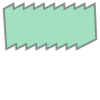

In [4]:
# Find out full parent cell id corresponding to the child (data projected ) cell_ids 

parent_level = 10

# 2) Map child ids to parent ids
parent_ids = healpix_geo.nested.zoom_to(
    child_ids,
    depth=child_level,
    new_depth=parent_level,
)
parent_ids, counts = np.unique(parent_ids, return_counts=True)

print(f"N parent level {parent_level} cells: {parent_ids.size}")
# save parent_ids
np.savez("parent_ids.npz", 
         parent_ids=parent_ids, 
         parent_level=parent_level,)
#plot the parent cell ids 
get_boundary(parent_ids,parent_level)

## Step 4 — Build boundary footprint (parent + outer ring) and export GeoJSON


In [5]:
# translate these parent_cell ids in edge_level. 
edge_level = child_level- 2
print("boundary region is in level", edge_level)
##keep only the outer boundary cells from edges_ids
#edges_ids = healpix_geo.nested.internal_boundary(edge_level, edges_ids)
edges_ids = healpix_geo.nested.zoom_to(
#    boundary_parents_ids,  
     parent_ids,
    depth=parent_level,
    new_depth=edge_level,
)
edges_ids  = np.unique(edges_ids, return_counts=False)
print(f"N edges level {edge_level} cells: {edges_ids.size}")

#get_boundary(edges_ids,edge_level)


boundary region is in level 11
N edges level 11 cells: 284


N edges level 11 outer edges cells: 384


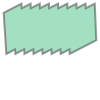

In [6]:
#find N+1 neighbour in edge_level
outer_edges_ids = np.unique(
    healpix_geo.nested.kth_neighbourhood(
        edges_ids,
        edge_level, ring=1, num_threads=0),#return_counts=True
)
print(f"N edges level {edge_level} outer edges cells: {outer_edges_ids.size}")
outer_boundary=get_boundary(outer_edges_ids,edge_level)
outer_boundary

In [7]:

gdf = gpd.GeoDataFrame(
    {"name": ["outer_boundary"]},
    geometry=[outer_boundary],
    crs="EPSG:4326",
)

gdf.to_file("outer_boundary.geojson", driver="GeoJSON")


<Axes: >

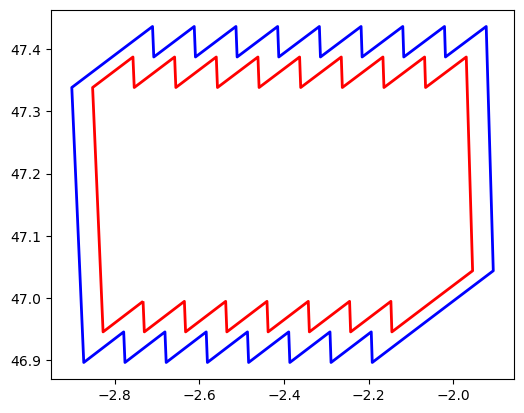

In [8]:
gdf_fp = gpd.GeoDataFrame(
    {"name": ["parent_ids"]},
    geometry=[get_boundary(parent_ids,parent_level,plot=False)],
    crs="EPSG:4326",
)
ax = gdf_fp.plot(edgecolor="red", facecolor="none", linewidth=2)
ax.set_aspect("equal")
gdf.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=2)
